In [3]:
import numpy as np
import pandas as pd

# импорт моделей
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report # табличка с метриками

import matplotlib.pyplot as plt
from collections import Counter

In [4]:

data = pd.read_csv("news_fake-n-true.csv")
data.head(10)

,Unnamed: 0,title,text,subject,date,label
0,0,ADVISORY: Story on Kushner visiting Iraq withd...,(Reuters) - The story “Trump son-in-law Jared ...,politicsNews,"April 3, 2017",1
1,1,Kasich campaign denies report of Romney endors...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 14, 2016",1
2,2,WATCH: Colbert Devises Perfect Advertisement ...,If America is going to end the day Donald Trum...,News,"May 20, 2016",0
3,3,Trump says hopes for Cuban 'freedom' after Cas...,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",politicsNews,"November 26, 2016",1
4,4,Trump Whines Pathetically On Twitter Because ...,"Well, it seems that despite the efforts of not...",News,"July 17, 2017",0
5,5,MEALS ON WHEELS Shuts the Lyin’ Lefties Up Wit...,Below is the comment in red that MoveOn.org pu...,Government News,"Mar 19, 2017",0
6,6,Obama thinks regular U.S. tourism to Cuba coul...,(Reuters) - Regular tourism to Cuba by U.S. ci...,politicsNews,"March 21, 2016",1
7,7,Trump spoke by phone to Egypt's Sisi to discus...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"June 9, 2017",1
8,8,OOPS! UKRAINE Caught Colluding With Democrats ...,Donald Trump wasn t the only presidential cand...,politics,"Jan 13, 2017",0
9,9,Giuliani To Black Fathers: ‘Real Danger’ To Y...,Former New York City mayor Rudy Giuliani told ...,News,"July 10, 2016",0


In [5]:
data_clean = data.drop(['Unnamed: 0','title','subject','date'], axis=1) # Удалили ненужное

display(data_clean)

,text,label
0,(Reuters) - The story “Trump son-in-law Jared ...,1
1,WASHINGTON (Reuters) - Republican presidential...,1
2,If America is going to end the day Donald Trum...,0
3,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",1
4,"Well, it seems that despite the efforts of not...",0
...,...,...
44893,Donald Trump s economic proposals would be dis...,0
44894,INDIANAPOLIS (Reuters) - President Donald Trum...,1
44895,During a private meeting of the most senior Re...,0
44896,"AMMAN (Reuters) - Sabih al-Masri, Jordan s mos...",1


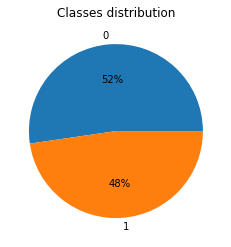

In [6]:
classes =pd.value_counts(data_clean["label"]) # посмотрели сколько каких новостей 

classes.plot(kind = 'pie',  autopct='%0.f%%') 
plt.title("Classes distribution")
plt.ylabel('')

plt.show()

In [7]:

Counter(" ".join(data[data['label']==0]["text"]).split()).most_common(50) # посмотрели самые частые слова

[('the', 483203),
 ('to', 286028),
 ('of', 233193),
 ('and', 213059),
 ('a', 202870),
 ('in', 152840),
 ('that', 138416),
 ('s', 127621),
 ('is', 105555),
 ('for', 88389),
 ('on', 76951),
 ('was', 66430),
 ('Trump', 64844),
 ('he', 62175),
 ('with', 60672),
 ('his', 55840),
 ('it', 53935),
 ('as', 51541),
 ('be', 47483),
 ('by', 45791),
 ('have', 45252),
 ('are', 44469),
 ('I', 42453),
 ('has', 41777),
 ('not', 41032),
 ('this', 41024),
 ('who', 40634),
 ('The', 40127),
 ('t', 39421),
 ('from', 39393),
 ('at', 38276),
 ('they', 37006),
 ('an', 33976),
 ('about', 31681),
 ('you', 30418),
 ('their', 29577),
 ('we', 26261),
 ('or', 23523),
 ('her', 23391),
 ('but', 23226),
 ('will', 23083),
 ('would', 23024),
 ('been', 22734),
 ('people', 21266),
 ('were', 21241),
 ('said', 21112),
 ('she', 20339),
 ('all', 20336),
 ('out', 20219),
 ('what', 20123)]

In [8]:
count1 = Counter(" ".join(data[data['label']==0]["text"]).lower().split()).most_common(20) # то же самое, только датафрейм
df1 = pd.DataFrame.from_dict(count1) # новый дф
df1 = df1.rename(columns={0: "words in real", 1 : "count"})

# тот же набор операций для второго подкорпуса
count2 = Counter(" ".join(data[data['label']==1]["text"]).lower().split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in fake", 1 : "count"})

display(df1,df2)

,words in real,count
0,the,525528
1,to,288565
2,of,235161
3,and,222329
4,a,209598
5,in,162846
6,that,144901
7,s,128331
8,is,107720
9,for,91066


,words in fake,count
0,the,477832
1,to,244369
2,of,204654
3,a,196601
4,and,180796
5,in,179501
6,on,107739
7,that,84922
8,for,79112
9,said,72035


In [9]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english') # векторизация с удалением стоп-слов

In [10]:
text = data["text"]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
X = f.fit_transform(text) # векторизовали
display(X.shape)

(44898, 121690)

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], 
                                                                    test_size=0.2, random_state=50)
# разделили данные для тренировки и для теста
print(X_train.shape, X_test.shape)
sum(y_test == 1)

(35918, 121690) (8980, 121690)


4262

In [13]:
list_alpha = np.arange(1/100000, 20, 0.11)  # в цикле будем перебирать альфы и посмотрим, где лучше получится 
#обучить модель

score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0

In [14]:
for alpha in list_alpha: # для каждого значения в списке альф
    bayes = naive_bayes.MultinomialNB(alpha=alpha) # используем модель наивный байес
    bayes.fit(X_train, y_train) # тренируем модель
    
    score_train[count] = bayes.score(X_train, y_train) # итерируемся по индексу в листе, добавляем значения accuracy
    # score_train? 
    
    score_test[count]= bayes.score(X_test, y_test)
    # score_test ? 
    
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    
    count = count + 1 # после одной итерации, делаем новый шаг

In [15]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])


display(models.head(10))

display(matrix.shape)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.978534,0.960690,0.947677,0.968817
1,0.11001,0.964419,0.958018,0.953778,0.957597
2,0.22001,0.962804,0.957906,0.954012,0.957156
3,0.33001,0.961858,0.957461,0.953778,0.956471
4,0.44001,0.961022,0.956793,0.953778,0.955122
5,0.55001,0.960187,0.956347,0.953543,0.954439
6,0.66001,0.959575,0.955679,0.953074,0.953521
7,0.77001,0.959101,0.955345,0.953074,0.952850
8,0.88001,0.958823,0.955011,0.953308,0.951968
9,0.99001,0.958544,0.954120,0.952604,0.950820


(182, 5)

In [16]:
best_index = models['Test Precision'].idxmax() # видим: альфа 0.00001 самая удачная
display(models.iloc[best_index])

alpha             0.000010
Train Accuracy    0.978534
Test Accuracy     0.960690
Test Recall       0.947677
Test Precision    0.968817
Name: 0, dtype: float64

In [17]:

bayes = naive_bayes.MultinomialNB(alpha= 0.000010) # используем лучшую модель
bayes.fit(X_train, y_train) # тренируем алгоритм на данных

bayes.predict(X_test) # метод для предсказания

# сделаем датафрейм с колонками для настоящего класса и для предсказанного

new_df = pd.DataFrame(data = y_test)
new_df["predicted"]=bayes.predict(X_test) # добавляем новую колонку с предсказаниями

new_df

,label,predicted
18322,0,0
6805,0,0
11776,0,0
43603,1,1
1166,1,1
...,...,...
3814,0,0
27520,1,1
11071,0,1
2479,0,0


In [18]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
# смотрим матрицу ошибок. (по сути 4588 угадано верно 0, 130 угадано неверно. Так же для единицы)
# как видим, результаты скудноваты, но приемлемы
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,4588,130
Actual 1,223,4039


In [26]:
svclassifier = svm.SVC(kernel='linear') # делаем метод опорных векторов 
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [27]:
m_confusion_test = metrics.confusion_matrix(y_test, svclassifier.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])
# смотрим матрицу: результаты отличные 

,Predicted 0,Predicted 1
Actual 0,4700,18
Actual 1,20,4242
